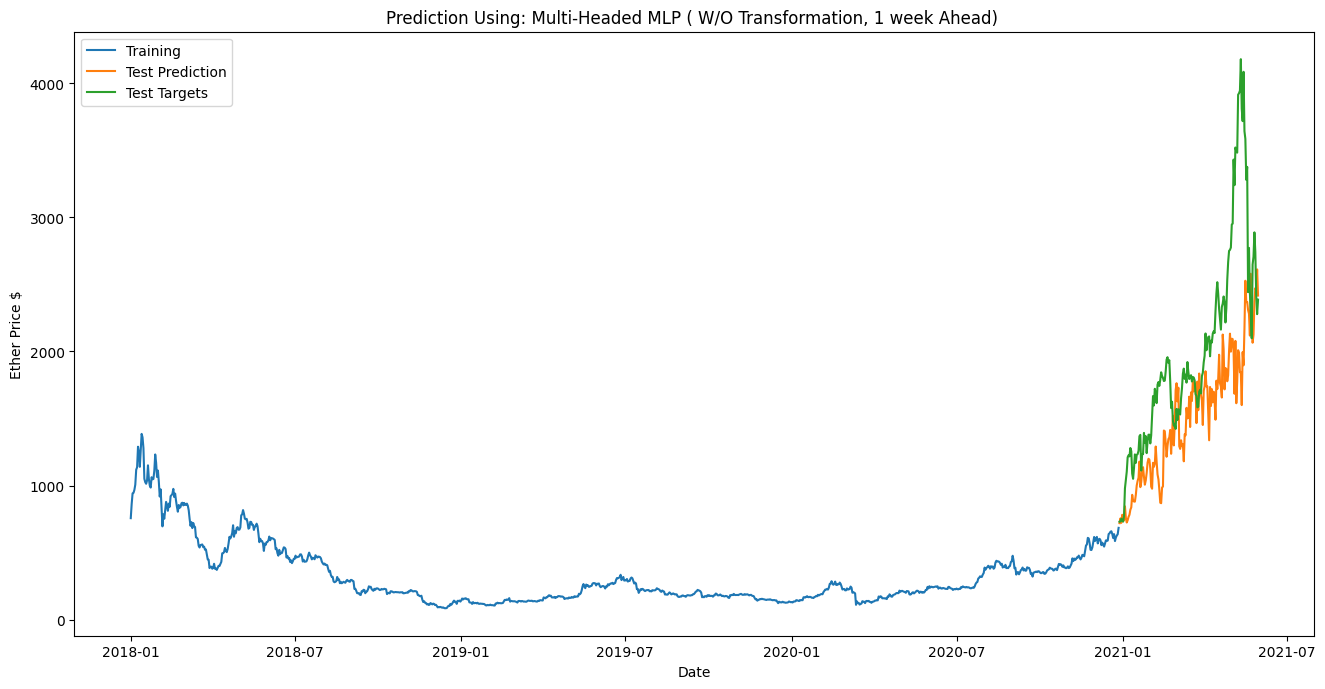

Total RMSE is:  693.9781461711159
Total APE is:  22.47922263471797
Runtime of the program is 2567.6859011650085


In [50]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split a multivariate sequence into samples for providing test samples
def split_sequences_test(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(int(len(sequences)/n_steps_out)):
        # find the end of this pattern
        end_ix = i*n_steps_out + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i*n_steps_out:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
    
    
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
#df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 7

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences_test(sequences_test, n_input, n_out)

#train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=0.3, random_state=2)

n_features = train_x.shape[2]

#--------------------------
# CNN
#--------------------------

# separate input data
X=[train_x[:, :, i] for i in range(n_features)]


# input model
visible= [Input(shape=(n_input,1)) for i in range(n_features)]
cnn = [Conv1D(filters=64, kernel_size=2, activation='relu')(visible[i]) for i in range(n_features)]
cnn = [MaxPooling1D(pool_size=2)(cnn[i]) for i in range(n_features)]
cnn = [Flatten()(cnn[i]) for i in range(n_features)]

# merge input models
merge = concatenate([cnn[i] for i in range(n_features)])
dense = Dense(500, activation='relu')(merge)
output = Dense(n_out)(dense)
model_cnn = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
model_cnn.compile(optimizer='adam', loss='mse')
# fit model
model_cnn.fit(X, train_y, epochs=2000, verbose=0)

# evaluate predictions days for each week
XX = [test_x[:, :, i] for i in range(n_features)]
predictions = model_cnn.predict(XX, verbose=0)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1])
        

# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev=(scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")